# Vertex AI Pipelines: Pipelines introduction for KFP


## Overview

This notebook provides an introduction to using [Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines) with [the Kubeflow Pipelines (KFP) SDK](https://www.kubeflow.org/docs/components/pipelines/).

### Learning objectives

1. Initialize Vertex AI SDK for Python.
2. Compile the pipeline.
3. Run the pipeline.
4. Specify a service account to use for a pipeline run.
5. Use the Pipelines REST API.

Each learning objective will correspond to a __#TODO__ in this student lab notebook -- try to complete this notebook first and then review the [solution notebook](../solutions/pipelines_intro_kfp.ipynb).

## Installation

Install the packages required for executing this notebook.

In [1]:
import os

# The Vertex AI Workbench Notebook product has specific requirements
IS_WORKBENCH_NOTEBOOK = os.getenv("DL_ANACONDA_HOME") and not os.getenv("VIRTUAL_ENV")
IS_USER_MANAGED_WORKBENCH_NOTEBOOK = os.path.exists(
    "/opt/deeplearning/metadata/env_version"
)

# Vertex AI Notebook requires dependencies to be installed with '--user'
USER_FLAG = ""
if IS_WORKBENCH_NOTEBOOK:
    USER_FLAG = "--user"

! pip3 install --upgrade google-cloud-aiplatform {USER_FLAG} -q
! pip3 install -U google-cloud-storage {USER_FLAG} -q
! pip3 install {USER_FLAG} kfp google-cloud-pipeline-components --upgrade -q

  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
  Consider adding this directory to PATH or, if you prefer to suppress this warning, use --no-warn-script-location.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
tfx-bsl 1.10.1 requires pyarrow<7,>=6, but you have pyarrow 9.0.0 which is incompatible.
tfx-bsl 1.10.1 requires tensorflow!=2.0.*,!=2.1.*,!=2.2.*,!=2.3.*,!=2.4.*,!=2.5.*,!=2.6.*,!=2.7.*,!=2.8.*,<3,>=1.15.5, but you have tensorflow 2.6.5 which is incompatible.
tensorfl

### Restart the kernel

Once you've installed the additional packages, you need to restart the notebook kernel so it can find the packages.

In [2]:
import os

if not os.getenv("IS_TESTING"):
    # Automatically restart kernel after installs
    import IPython

    app = IPython.Application.instance()
    app.kernel.do_shutdown(True)

Check the versions of the packages you installed.  The KFP SDK version should be >=1.6.

In [1]:
! python3 -c "import kfp; print('KFP SDK version: {}'.format(kfp.__version__))"

KFP SDK version: 1.8.14


In [2]:
PROJECT_ID = "qwiklabs-gcp-01-d69e76763702"  # @param {type:"string"}

In [3]:
! gcloud config set project $PROJECT_ID

Updated property [core/project].


#### Region

You can also change the `REGION` variable, which is used for operations
throughout the rest of this notebook.  Below are regions supported for Vertex AI. We recommend that you choose the region closest to you.

- Americas: `us-central1`
- Europe: `europe-west4`
- Asia Pacific: `asia-east1`

You may not use a multi-regional bucket for training with Vertex AI. Not all regions provide support for all Vertex AI services.

Learn more about [Vertex AI regions](https://cloud.google.com/vertex-ai/docs/general/locations)

In [4]:
REGION = "us-central1"  # @param {type:"string"}

In [5]:
if REGION == "[your-region]":
    REGION = "us-central1"

#### Timestamp

If you are in a live tutorial session, you might be using a shared test account or project. To avoid name collisions between users on resources created, you create a timestamp for each instance session, and append the timestamp onto the name of resources you create in this tutorial.

In [6]:
from datetime import datetime

TIMESTAMP = datetime.now().strftime("%Y%m%d%H%M%S")

### Create a Cloud Storage bucket

**The following steps are required, regardless of your notebook environment.**

When you initialize the Vertex AI SDK for Python, you specify a Cloud Storage staging bucket. The staging bucket is where all the data associated with your dataset and model resources are retained across sessions.

Set the name of your Cloud Storage bucket below. Bucket names must be globally unique across all Google Cloud projects, including those outside of your organization.

In [7]:
BUCKET_NAME = "[your-bucket-name]"  # Replace with your bucket name
BUCKET_URI = f"gs://{BUCKET_NAME}"

In [ ]:
if BUCKET_NAME == "" or BUCKET_NAME is None or BUCKET_NAME == "[your-bucket-name]":
    BUCKET_NAME = PROJECT_ID + "aip-" + TIMESTAMP
    BUCKET_URI = "gs://" + BUCKET_NAME

**Only if your bucket doesn't already exist**: Run the following cell to create your Cloud Storage bucket.

In [8]:
! gsutil mb -l $REGION $BUCKET_URI

Creating gs://qwiklabs-gcp-01-d69e76763702/...


Finally, validate access to your Cloud Storage bucket by examining its contents:

In [9]:
! gsutil ls -al $BUCKET_URI

#### Service Account

**If you don't know your service account**, try to get your service account using `gcloud` command by executing the second cell below.

In [10]:
SERVICE_ACCOUNT = "[your-service-account]"  # Replace with your service account

#### Set service account access for Vertex AI Pipelines

Run the following commands to grant your service account access to read and write pipeline artifacts in the bucket that you created in the previous step -- you only need to run these once per service account.

In [11]:
! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectCreator $BUCKET_URI

! gsutil iam ch serviceAccount:{SERVICE_ACCOUNT}:roles/storage.objectViewer $BUCKET_URI

### Set up variables

Next, set up some variables used throughout the tutorial.
### Import libraries and define constants

In [12]:
from typing import NamedTuple

import google.cloud.aiplatform as aip
from kfp import dsl
from kfp.v2 import compiler
from kfp.v2.dsl import component

#### Vertex AI constants

Setup up the following constants for Vertex AI:

- `API_ENDPOINT`: The Vertex AI API service endpoint for `Dataset`, `Model`, `Job`, `Pipeline` and `Endpoint` services.

In [13]:
# API service endpoint
API_ENDPOINT = "{}-aiplatform.googleapis.com".format(REGION)

#### Vertex AI Pipelines constants

Setup up the following constants for Vertex AI Pipelines:

In [14]:
PIPELINE_ROOT = "{}/pipeline_root/intro".format(BUCKET_URI)

## Initialize Vertex AI SDK for Python

Initialize the Vertex AI SDK for Python for your project and corresponding bucket.

In [15]:
# Initialize the Vertex AI SDK for your project and bucket
# TODO 1: Your code goes here

### Define Python function-based pipeline components

In this tutorial, you define a simple pipeline that has three steps, where each step is defined as a component.

#### Define hello_world component

First, define a component based on a very simple Python function. It takes a string input parameter and returns that value as output.

Note the use of the `@component` decorator, which compiles the function to a KFP component when evaluated.  For example purposes, this example specifies a base image to use for the component (`python:3.9`), and a component YAML file, `hw.yaml`. The compiled component specification is written to this file.  (The default base image is `python:3.7`, which would of course work just fine too).

In [16]:
@component(output_component_file="hw.yaml", base_image="python:3.9")
def hello_world(text: str) -> str:
    print(text)
    return text

As you'll see below, compilation of this component creates a [task factory function](https://www.kubeflow.org/docs/components/pipelines/sdk/python-function-components/)—called `hello_world`— that you can use in defining a pipeline step.

While not shown here, if you want to share this component definition, or use it in another context, you could also load it from its yaml file like this:
`hello_world_op = components.load_component_from_file('./hw.yaml')`.
You can also use the `load_component_from_url` method, if your component yaml file is stored online. (For GitHub URLs, load the 'raw' file.)

#### Define two_outputs component

The first component below, `two_outputs`, demonstrates installing a package -- in this case the `google-cloud-storage` package. Alternatively, you can specify a base image that includes the necessary installations.

*Note:* The component function won't actually use the package.

Alternatively, you can specify a base image that includes the necessary installations.

The `two_outputs` component returns two named outputs.

In [17]:
@component(packages_to_install=["google-cloud-storage"])
def two_outputs(
    text: str,
) -> NamedTuple(
    "Outputs",
    [
        ("output_one", str),  # Return parameters
        ("output_two", str),
    ],
):
    # the import is not actually used for this simple example, but the import
    # is successful, as it was included in the `packages_to_install` list.
    from google.cloud import storage  # noqa: F401

    o1 = f"output one from text: {text}"
    o2 = f"output two from text: {text}"
    print("output one: {}; output_two: {}".format(o1, o2))
    return (o1, o2)

#### Define the consumer component

The third component, `consumer`, takes three string inputs and prints them out.

In [18]:
@component
def consumer(text1: str, text2: str, text3: str):
    print(f"text1: {text1}; text2: {text2}; text3: {text3}")

### Define a pipeline that uses the components

Next, define a pipeline that uses these three components.

By evaluating the component definitions above, you've created task factory functions that are used in the pipeline definition to create the pipeline steps.

The pipeline takes an input parameter, and passes that parameter as an argument to the first two pipeline steps (`hw_task` and `two_outputs_task`).

Then, the third pipeline step (`consumer_task`) consumes the outputs of the first and second steps.  Because the `hello_world` component definition just returns one unnamed output, you refer to it as `hw_task.output`.  The `two_outputs` task returns two named outputs, which you access as `two_outputs_task.outputs["<output_name>"]`.

*Note:* In the `@dsl.pipeline` decorator, you're defining the `PIPELINE_ROOT` Cloud Storage path to use.  If you had not included that info here, it would be required to specify it when creating the pipeline run, as you'll see below.

In [19]:
@dsl.pipeline(
    name="hello-world-v2",
    description="A simple intro pipeline",
    pipeline_root=PIPELINE_ROOT,
)
def pipeline(text: str = "hi there"):
    hw_task = hello_world(text)
    two_outputs_task = two_outputs(text)
    consumer_task = consumer(  # noqa: F841
        hw_task.output,
        two_outputs_task.outputs["output_one"],
        two_outputs_task.outputs["output_two"],
    )

## Compile the pipeline

Next, compile the pipeline.

In [20]:
# Compile the pipeline
from kfp.v2 import compiler  # noqa: F811

compiler.Compiler().compile(# TODO 2: Your code goes here)

/home/jupyter/.local/lib/python3.7/site-packages/kfp/v2/compiler/compiler.py:1293: FutureWarning: APIs imported from the v1 namespace (e.g. kfp.dsl, kfp.components, etc) will not be supported by the v2 compiler since v2.0.0
  category=FutureWarning,


## Run the pipeline

Next, run the pipeline.

In [21]:
# Create and run the pipeline job run
DISPLAY_NAME = "intro_" + TIMESTAMP

job = # TODO 3: Your code goes here

job.run()

Creating PipelineJob
PipelineJob created. Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922141223
To use this PipelineJob in another session:
pipeline_job = aiplatform.PipelineJob.get('projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922141223')
View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/hello-world-v2-20220922141223?project=192756378758
PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922141223 current state:
PipelineState.PIPELINE_STATE_PENDING
PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922141223 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922141223 current state:
PipelineState.PIPELINE_STATE_RUNNING
PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-wo

Click on the generated link to see your run in the Cloud Console.

<!-- It should look something like this as it is running:

<a href="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" target="_blank"><img src="https://storage.googleapis.com/amy-jo/images/mp/automl_tabular_classif.png" width="40%"/></a> -->

In the UI, many of the pipeline DAG nodes will expand or collapse when you click on them. Here is a partially-expanded view of the DAG (click image to see larger version).

<a href="https://storage.googleapis.com/amy-jo/images/mp/intro_pipeline.png" target="_blank"><img src="https://storage.googleapis.com/amy-jo/images/mp/intro_pipeline.png" width="60%"/></a>

### Delete the pipeline job

You can delete the pipeline job with the method `delete()`.

In [22]:
job.delete()

Deleting PipelineJob : projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922141223
Delete PipelineJob  backing LRO: projects/192756378758/locations/us-central1/operations/5955010295213588480
PipelineJob deleted. . Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922141223


## Recurring pipeline runs: create a scheduled pipeline job

This section shows how to create a **scheduled pipeline job**.  You do this using the pipeline you already defined.

Under the hood, the scheduled jobs are supported by the Cloud Scheduler and a Cloud Functions function.  Check first that the APIs for both of these services are enabled.
**You will need to first enable the [enable the Cloud Scheduler API](http://console.cloud.google.com/apis/library/cloudscheduler.googleapis.com) and the [Cloud Functions and Cloud Build APIs](https://console.cloud.google.com/flows/enableapi?apiid=cloudfunctions,cloudbuild.googleapis.com) if you have not already done so.**
**Note:** you need to [create an App Engine app for your project](https://cloud.google.com/scheduler/docs/quickstart) if one does not already exist.


See the [Cloud Scheduler](https://cloud.google.com/scheduler/docs/configuring/cron-job-schedules) documentation for more on the cron syntax.

Create a scheduled pipeline job, passing as an argument the job specification file that you compiled above.

*Note:* You can pass a `parameter_values` dict that specifies the pipeline input parameters you want to use.

In [23]:
import os

In [24]:
if not os.getenv("IS_TESTING"):
    from kfp.v2.google.client import AIPlatformClient  # noqa: F811

    api_client = AIPlatformClient(project_id=PROJECT_ID, region=REGION)

    # adjust time zone and cron schedule as necessary
    response = api_client.create_schedule_from_job_spec(
        job_spec_path="intro_pipeline.json",
        schedule="2 * * * *",
        time_zone="America/Los_Angeles",  # change this as necessary
        parameter_values={"text": "Hello world!"},
        # pipeline_root=PIPELINE_ROOT  # this argument is necessary if you did not specify PIPELINE_ROOT as part of the pipeline definition.
    )

Once the scheduled job is created, you can see it listed in the [Cloud Scheduler](https://console.cloud.google.com/cloudscheduler/) panel in the Console.

<a href="https://storage.googleapis.com/amy-jo/images/kf-pls/pipelines_scheduler.png" target="_blank"><img src="https://storage.googleapis.com/amy-jo/images/kf-pls/pipelines_scheduler.png" width="95%"/></a>

You can test the setup from the Cloud Scheduler panel by clicking 'RUN NOW'.

> **Note**: The implementation is using a Cloud Functions function, which you can see listed in the [Cloud Functions](https://console.cloud.google.com/functions/list) panel in the console as `templated_http_request-v1`.
Don't delete this function, as it will prevent the Cloud Scheduler jobs from actually kicking off the pipeline run.  If you do delete it, create a new scheduled job in order to recreate the function.

When you're done experimenting, you probably want to **PAUSE** your scheduled job from the Cloud Scheduler panel, so that the recurrent jobs do not keep running.

## Specifying a service account to use for a pipeline run

By default, the [service account](https://cloud.google.com/iam/docs/service-accounts) used for your pipeline run is your [default compute engine service account](https://cloud.google.com/compute/docs/access/service-accounts#default_service_account).
However, you might want to run pipelines with permissions to access different roles than those configured for your default SA (e.g. perhaps using a more restricted set of permissions).

If you want to execute your pipeline using a different service account, this is straightforward to do.  You just need to give the new service account the correct permissions.

### Create a service account

Once your service account is configured, you pass it as an argument to the `create_run_from_job_spec` method. The pipeline job runs with the permissions of the given service account.

Learn about [creating and configuring a service account to work with Vertex AI Pipelines](https://cloud.google.com/vertex-ai/docs/pipelines/configure-project#service-account).

In [25]:
if not os.getenv("IS_TESTING"):
    response = api_client.create_run_from_job_spec(
        job_spec_path="intro_pipeline.json",
        pipeline_root=PIPELINE_ROOT,
        service_account=SERVICE_ACCOUNT,  # <-- CHANGE to use non-default service account
    )

## Pipeline step caching

By default, pipeline step caching is enabled. This means that the results of previous step executions are reused when possible.

if you want to disable caching for a pipeline run, you can pass the `enable_caching=False` argument to the `PipelineJob` constructor when you submit the pipeline job, as shown below.  Try submitting the example pipeline job again, first with and then without caching enabled.

In [26]:
# Disable caching for a pipeline run
job = aip.PipelineJob(# TODO 4: Your code goes here
)

job.run()

Creating PipelineJob


INFO:google.cloud.aiplatform.pipeline_jobs:Creating PipelineJob


PipelineJob created. Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob created. Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


To use this PipelineJob in another session:


INFO:google.cloud.aiplatform.pipeline_jobs:To use this PipelineJob in another session:


pipeline_job = aiplatform.PipelineJob.get('projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250')


INFO:google.cloud.aiplatform.pipeline_jobs:pipeline_job = aiplatform.PipelineJob.get('projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250')


View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/hello-world-v2-20220922143250?project=192756378758


INFO:google.cloud.aiplatform.pipeline_jobs:View Pipeline Job:
https://console.cloud.google.com/vertex-ai/locations/us-central1/pipelines/runs/hello-world-v2-20220922143250?project=192756378758


PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250 current state:
PipelineState.PIPELINE_STATE_RUNNING


PipelineJob run completed. Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


INFO:google.cloud.aiplatform.pipeline_jobs:PipelineJob run completed. Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


### Delete the pipeline job

You can delete the pipeline job with the method `delete()`.

In [27]:
job.delete()

Deleting PipelineJob : projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


INFO:google.cloud.aiplatform.base:Deleting PipelineJob : projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


Delete PipelineJob  backing LRO: projects/192756378758/locations/us-central1/operations/8227076307222003712


INFO:google.cloud.aiplatform.base:Delete PipelineJob  backing LRO: projects/192756378758/locations/us-central1/operations/8227076307222003712


PipelineJob deleted. . Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


INFO:google.cloud.aiplatform.base:PipelineJob deleted. . Resource name: projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143250


## Using the Pipelines REST API

At times you may want to use the REST API instead of the Python KFP SDK.  Below are examples of how to do that.

Where a command requires a pipeline ID, you can get that info from the "Run" column in the pipelines list— as shown below— as well as from the 'details' page for a given pipeline.  You can also see that info when you list pipeline job(s) via the API.

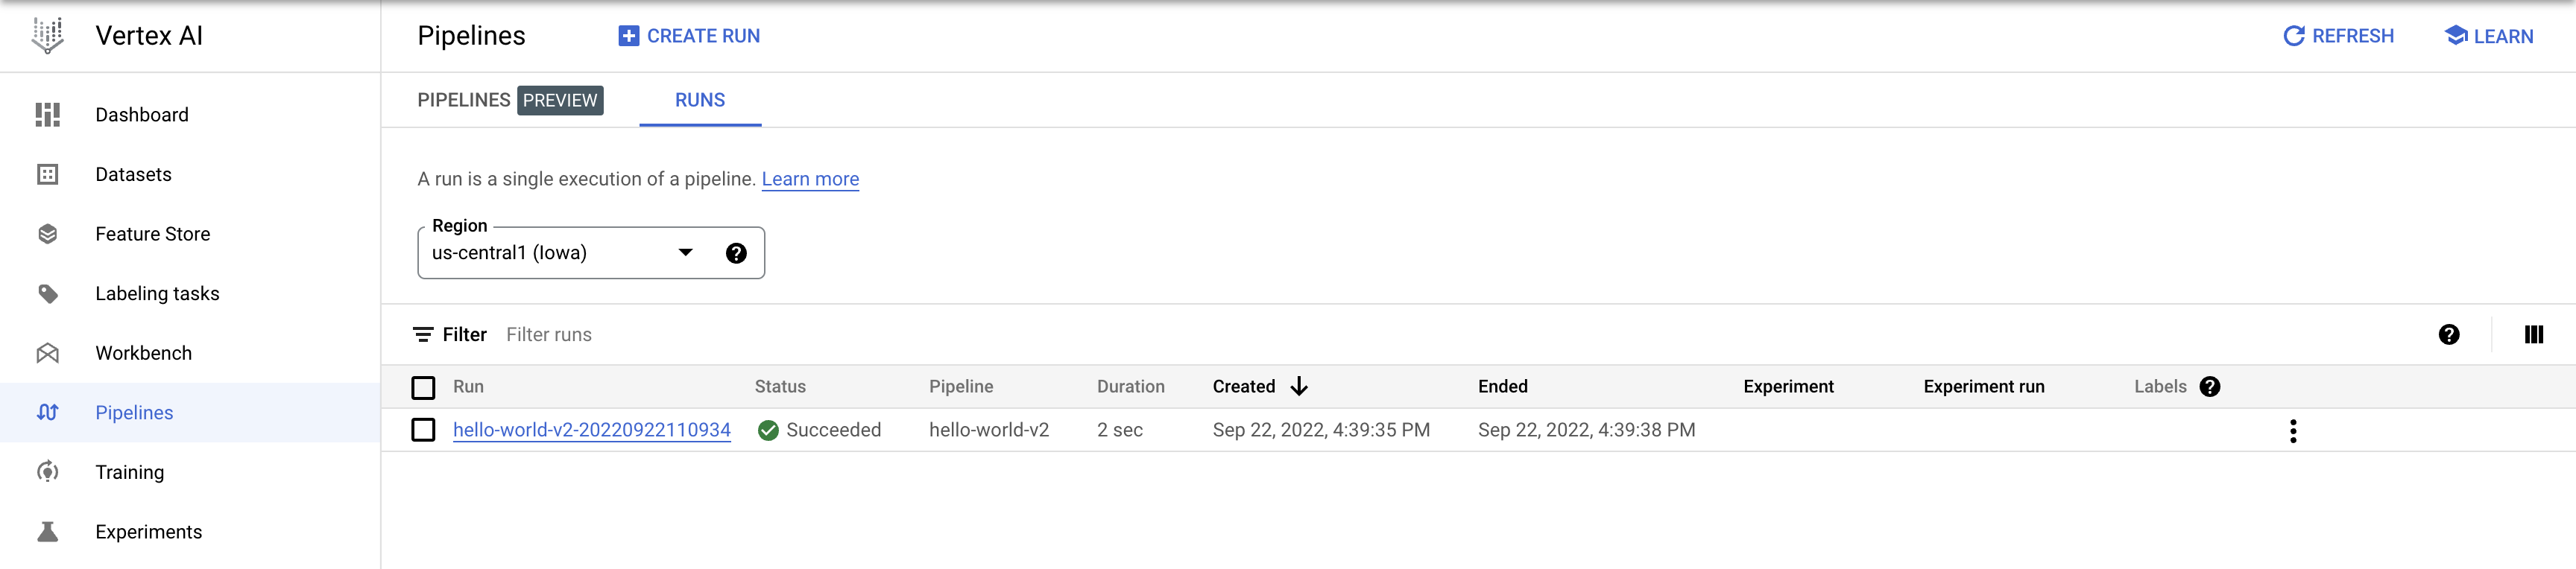

### List pipeline jobs

*Note:* This request may generate a large response if you have many pipeline runs.

In [28]:
! curl -X GET -H "Authorization: Bearer $(gcloud auth print-access-token)"   -H "Content-Type: application/json"   https://{API_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{REGION}/pipelineJobs

{
  "pipelineJobs": [
    {
      "name": "projects/192756378758/locations/us-central1/pipelineJobs/hello-world-v2-20220922143209",
      "displayName": "hello-world-v2-20220922143209",
      "createTime": "2022-09-22T14:32:09.858920Z",
      "startTime": "2022-09-22T14:32:10.420175Z",
      "endTime": "2022-09-22T14:32:12.894671Z",
      "updateTime": "2022-09-22T14:32:12.894671Z",
      "pipelineSpec": {
        "deploymentConfig": {
          "@type": "type.googleapis.com/ml_pipelines.PipelineDeploymentConfig",
          "executors": {
            "exec-consumer": {
              "container": {
                "image": "python:3.7",
                "command": [
                  "sh",
                  "-c",
                  "\nif ! [ -x \"$(command -v pip)\" ]; then\n    python3 -m ensurepip || python3 -m ensurepip --user || apt-get install python3-pip\nfi\n\nPIP_DISABLE_PIP_VERSION_CHECK=1 python3 -m pip install --quiet     --no-warn-script-location 'kfp==1.8.14' && \"$0\" \"$@\"

### Create a pipeline job

For this REST request, you submit a compiled pipeline job specification.  We're using the one you generated previously.

In [29]:
output = ! curl -X POST  -H "Authorization: Bearer $(gcloud auth print-access-token)" -H "Content-Type: application/json; charset=utf-8"   https://{API_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{REGION}/pipelineJobs  --data "@intro_pipeline.json"

# Enter the pipeline run id
PIPELINE_RUN_ID = # TODO 5: Your code goes here
print(output)

['  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current', '                                 Dload  Upload   Total   Spent    Left  Speed', '', '  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0{', '  "name": "projects/192756378758/locations/us-central1/pipelineJobs/184807013908217856",', '  "createTime": "2022-09-22T14:39:04.069052Z",', '  "updateTime": "2022-09-22T14:39:04.069052Z",', '  "pipelineSpec": {', '    "deploymentConfig": {', '      "@type": "type.googleapis.com/ml_pipelines.PipelineDeploymentConfig",', '      "executors": {', '        "exec-consumer": {', '          "container": {', '            "image": "python:3.7",', '            "command": [', '              "sh",', '              "-c",', '              "\\nif ! [ -x \\"$(command -v pip)\\" ]; then\\n    python3 -m ensurepip || python3 -m ensurepip --user || apt-get install python3-pip\\nfi\\n\\nPIP_DISABLE_PIP_VERSION_CHECK=1 python3 -m pip install --quiet     --no

### Get a pipeline job from its ID

In [30]:
! curl -X GET -H "Authorization: Bearer $(gcloud auth print-access-token)"   -H "Content-Type: application/json"   https://{API_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{REGION}/pipelineJobs/{PIPELINE_RUN_ID}

{
  "pipelineJobs": [
    {
      "name": "projects/192756378758/locations/us-central1/pipelineJobs/184807013908217856",
      "createTime": "2022-09-22T14:39:04.069052Z",
      "startTime": "2022-09-22T14:39:04.631583Z",
      "endTime": "2022-09-22T14:39:07.054511Z",
      "updateTime": "2022-09-22T14:39:07.054511Z",
      "pipelineSpec": {
        "deploymentConfig": {
          "@type": "type.googleapis.com/ml_pipelines.PipelineDeploymentConfig",
          "executors": {
            "exec-consumer": {
              "container": {
                "image": "python:3.7",
                "command": [
                  "sh",
                  "-c",
                  "\nif ! [ -x \"$(command -v pip)\" ]; then\n    python3 -m ensurepip || python3 -m ensurepip --user || apt-get install python3-pip\nfi\n\nPIP_DISABLE_PIP_VERSION_CHECK=1 python3 -m pip install --quiet     --no-warn-script-location 'kfp==1.8.14' && \"$0\" \"$@\"\n",
                  "sh",
                  "-ec",
           

### Cancel a pipeline job given its ID

In [31]:
! curl -X DELETE -H "Authorization: Bearer $(gcloud auth print-access-token)"   -H "Content-Type: application/json"   https://{API_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{REGION}/pipelineJobs/{PIPELINE_RUN_ID}

<!DOCTYPE html>
<html lang=en>
  <meta charset=utf-8>
  <meta name=viewport content="initial-scale=1, minimum-scale=1, width=device-width">
  <title>Error 404 (Not Found)!!1</title>
  <style>
    *{margin:0;padding:0}html,code{font:15px/22px arial,sans-serif}html{background:#fff;color:#222;padding:15px}body{margin:7% auto 0;max-width:390px;min-height:180px;padding:30px 0 15px}* > body{background:url(//www.google.com/images/errors/robot.png) 100% 5px no-repeat;padding-right:205px}p{margin:11px 0 22px;overflow:hidden}ins{color:#777;text-decoration:none}a img{border:0}@media screen and (max-width:772px){body{background:none;margin-top:0;max-width:none;padding-right:0}}#logo{background:url(//www.google.com/images/branding/googlelogo/1x/googlelogo_color_150x54dp.png) no-repeat;margin-left:-5px}@media only screen and (min-resolution:192dpi){#logo{background:url(//www.google.com/images/branding/googlelogo/2x/googlelogo_color_150x54dp.png) no-repeat 0% 0%/100% 100%;-moz-border-image:url(//www.

### Delete a pipeline job given its ID

In [32]:
! curl -X DELETE -H "Authorization: Bearer $(gcloud auth print-access-token)"   -H "Content-Type: application/json"   https://{API_ENDPOINT}/v1beta1/projects/{PROJECT_ID}/locations/{REGION}/pipelineJobs/{PIPELINE_RUN_ID}

<!DOCTYPE html>
<html lang=en>
  <meta charset=utf-8>
  <meta name=viewport content="initial-scale=1, minimum-scale=1, width=device-width">
  <title>Error 404 (Not Found)!!1</title>
  <style>
    *{margin:0;padding:0}html,code{font:15px/22px arial,sans-serif}html{background:#fff;color:#222;padding:15px}body{margin:7% auto 0;max-width:390px;min-height:180px;padding:30px 0 15px}* > body{background:url(//www.google.com/images/errors/robot.png) 100% 5px no-repeat;padding-right:205px}p{margin:11px 0 22px;overflow:hidden}ins{color:#777;text-decoration:none}a img{border:0}@media screen and (max-width:772px){body{background:none;margin-top:0;max-width:none;padding-right:0}}#logo{background:url(//www.google.com/images/branding/googlelogo/1x/googlelogo_color_150x54dp.png) no-repeat;margin-left:-5px}@media only screen and (min-resolution:192dpi){#logo{background:url(//www.google.com/images/branding/googlelogo/2x/googlelogo_color_150x54dp.png) no-repeat 0% 0%/100% 100%;-moz-border-image:url(//www.

# Cleaning up

To clean up all Google Cloud resources used in this project, you can [delete the Google Cloud
project](https://cloud.google.com/resource-manager/docs/creating-managing-projects#shutting_down_projects) you used for the tutorial.

Otherwise, you can delete the individual resources you created in this tutorial.

In [33]:
delete_pipeline = True
delete_bucket = True

try:
    if delete_pipeline and "DISPLAY_NAME" in globals():
        pipelines = aip.PipelineJob.list(
            filter=f"display_name={DISPLAY_NAME}", order_by="create_time"
        )
        pipeline = pipelines[0]
        aip.PipelineJob.delete(pipeline.resource_name)
        print("Deleted pipeline:", pipeline)
except Exception as e:
    print(e)

if delete_bucket or os.getenv("IS_TESTING"):
    ! gsutil rm -r $BUCKET_URI

list index out of range
Removing gs://qwiklabs-gcp-01-d69e76763702/pipeline_root/#1663856036655692...
Removing gs://qwiklabs-gcp-01-d69e76763702/pipeline_root/intro/#1663856036809239...
Removing gs://qwiklabs-gcp-01-d69e76763702/pipeline_root/intro/192756378758/#1663856036963636...
Removing gs://qwiklabs-gcp-01-d69e76763702/pipeline_root/intro/192756378758/hello-world-v2-20220922141223/#1663856037139451...
/ [4 objects]                                                                   
==> NOTE: You are performing a sequence of gsutil operations that may
run significantly faster if you instead use gsutil -m rm ... Please
see the -m section under "gsutil help options" for further information
about when gsutil -m can be advantageous.

Removing gs://qwiklabs-gcp-01-d69e76763702/pipeline_root/intro/192756378758/hello-world-v2-20220922141223/consumer_5276821833755131904/#1663856147426088...
Removing gs://qwiklabs-gcp-01-d69e76763702/pipeline_root/intro/192756378758/hello-world-v2-2022092214